# Practice Session 3: From Distributions to Statistical Thinking


In [141]:
import pandas as pd
import numpy as np
from numpy.random import default_rng

import seaborn as sns

from scipy import stats
from scipy.stats import skew, kurtosis, shapiro, kstest, norm

import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider
plt.rcParams["figure.figsize"] = (8, 8)

## Part 1: Revisiting the Wine Quality Dataset

Yesterday, we began exploring the **Wine Quality dataset** and learned how to visualize and analyze distributions.  
Before we move further, there are two very important points to revisit.

Let’s take another look at the dataset and recall how summary statistics are reported in Python.  
When we use the **`.describe()`** method, it automatically provides key descriptive measures such as the\
**mean**, **standard deviation**, **minimum**, **maximum**, and **quartiles** for each numeric variable.

However, not all functions in Python compute these statistics in exactly the same way.  
Today, we’ll check this by comparing different implementations of the **standard deviation**.



In [142]:
# Load the Wine Quality dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine_data = pd.read_csv(url, sep=";")

In [143]:
wine_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


#### <font color='#fc7202'> Task 1: </font>  
Using the **Wine Quality dataset**, calculate the **standard deviation** for all numeric variables with two different functions:

1. **`numpy.std()`**  
2. **`scipy.stats.tstd()`**

Then, compare the results with the standard deviation values shown in the `.describe()` summary table.  
Are all the results identical? If not, think about why they differ.

In [ ]:
columns_to_check = wine_data.columns[:-1] # exclude the 'quality' column
columns_to_check

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

We can calculate the standard deviations for all numeric columns at once by applying these functions directly to the dataset.  
Below, we first use `numpy.std()`, and then in the next cell we repeat the same with `scipy.stats.tstd()` to compare the results.

In [147]:
''' We set axis=0 to calculate the standard deviation column-wise,
meaning the function computes one value per variable (across all rows).
If we used axis=1 instead, it would calculate the standard deviation across columns for each row.'''
np.std(wine_data[columns_to_check], axis=0)

fixed acidity            1.740552
volatile acidity         0.179004
citric acid              0.194740
residual sugar           1.409487
chlorides                0.047051
free sulfur dioxide     10.456886
total sulfur dioxide    32.885037
density                  0.001887
pH                       0.154338
sulphates                0.169454
alcohol                  1.065334
dtype: float64

To make the comparison clearer, we can organize all results into a single `pandas DataFrame`.


In [155]:
'''We use reset_index(drop=True) to reset the DataFrame index after creation.
Without this, pandas would keep the old index (from the original columns) as an extra column.
Setting drop=True removes the old index instead of adding it as a new column,
giving us a clean, continuous index (0, 1, 2, …) for easier reading.'''

pd.DataFrame({'variable': columns_to_check,
              'numpy_std': np.std(wine_data[columns_to_check], axis=0),
              'scipy_tstd': stats.tstd(wine_data[columns_to_check], axis=0),
              'pandas_std': wine_data[columns_to_check].std(axis=0)}).reset_index(drop=True)

,variable,numpy_std,scipy_tstd,pandas_std
0,fixed acidity,1.740552,1.741096,1.741096
1,volatile acidity,0.179004,0.179060,0.179060
2,citric acid,0.194740,0.194801,0.194801
3,residual sugar,1.409487,1.409928,1.409928
4,chlorides,0.047051,0.047065,0.047065
5,free sulfur dioxide,10.456886,10.460157,10.460157
6,total sulfur dioxide,32.885037,32.895324,32.895324
7,density,0.001887,0.001887,0.001887
8,pH,0.154338,0.154386,0.154386
9,sulphates,0.169454,0.169507,0.169507


As we can see, the `SciPy` and `pandas` results align perfectly, while the `NumPy` implementation gives slightly smaller standard deviation values.  

The reason is that `NumPy`, by default, calculates the **population standard deviation**, dividing by **$N$** (the total number of observations).  
In contrast, `pandas` and `SciPy` use the **sample standard deviation**, dividing by **$n – 1$** (this adjustment is known as *Bessel’s correction*).  

Dividing by **$n – 1$** provides an unbiased estimate of the true population variance when working with sample data,\
which is why `pandas` and `SciPy` agree - they both assume you are analyzing a *sample*, not the entire population.

We can also use `NumPy`’s `std()` function to calculate the **sample standard deviation**.  
To do that, we simply set the parameter **`ddof=1`**, which tells NumPy to divide by **$n – 1$** instead of **$N$**.

The parameter `ddof` stands for **Delta Degrees of Freedom**. It adjusts the denominator used in the variance and standard deviation formulas:
\begin{equation} s = \sqrt{\frac{\sum (x_i - \bar{x})^2}{n - \text{ddof}}} \end{equation}

(By default, `NumPy` uses `ddof=0`, while both `pandas` and `SciPy` use `ddof=1`.)

> *A quick reminder:*  
> - **Degrees of freedom (df)** represent the number of independent pieces of information available to estimate a parameter.  
> - When we calculate the sample mean, one degree of freedom is “used up,” because all deviations must sum to zero. 


In [156]:
pd.DataFrame({'variable': columns_to_check,
              'numpy_std': np.std(wine_data[columns_to_check], ddof=1, axis=0), # set ddof=1
              'scipy_tstd': stats.tstd(wine_data[columns_to_check], axis=0),
              'pandas_std': wine_data[columns_to_check].std(axis=0)}).reset_index(drop=True)

,variable,numpy_std,scipy_tstd,pandas_std
0,fixed acidity,1.741096,1.741096,1.741096
1,volatile acidity,0.179060,0.179060,0.179060
2,citric acid,0.194801,0.194801,0.194801
3,residual sugar,1.409928,1.409928,1.409928
4,chlorides,0.047065,0.047065,0.047065
5,free sulfur dioxide,10.460157,10.460157,10.460157
6,total sulfur dioxide,32.895324,32.895324,32.895324
7,density,0.001887,0.001887,0.001887
8,pH,0.154386,0.154386,0.154386
9,sulphates,0.169507,0.169507,0.169507


#### Comparing Variability Across Variables  

As we can see, the standard deviations vary quite a lot between the variables.  
However, since each variable may have a **different mean and scale**, directly comparing their standard deviations isn’t very meaningful.  

To make the comparison fair, we can compute the **coefficient of variation (CV)**, which expresses the **standard deviation relative to the mean**:
\begin{equation} \text {CV} = \frac{s}{\bar{x}} \end{equation}



#### <font color='#fc7202'> Task 2: </font>  
Compute the **coefficient of variation** for each numeric variable in the dataset.  


In [162]:
np.std(wine_data[columns_to_check], ddof=1, axis=0)/np.mean(wine_data[columns_to_check], axis=0)

fixed acidity           0.209276
volatile acidity        0.339244
citric acid             0.718888
residual sugar          0.555351
chlorides               0.538095
free sulfur dioxide     0.658911
total sulfur dioxide    0.707917
density                 0.001893
pH                      0.046627
sulphates               0.257551
alcohol                 0.102242
dtype: float64

> *Note:*
>
> We can calculate the coefficient of variation for **many columns at once** because both `np.mean()` and `np.std()` can operate **column-wise** across a DataFrame.\
> For that we have to set `axis=0` (tells `NumPy` to compute along each column (i.e., across all rows)).\
> Both functions return one value per column:
>   - a vector of means and 
>   - a vector of standard deviations.
>
> Dividing these two vectors gives the CV for each column in a single step, without looping through variables one by one.

#### Revisiting the Kolgomorov-Smirnov (K-S) test

Yesterday we saw that we can use the **Kolmogorov–Smirnov (K–S) test** to check whether our data come from a normal distribution.  
This test compares the **empirical cumulative distribution function (ECDF)** of the data with the **theoretical cumulative distribution function (CDF)** of the normal distribution.

Before we look deeper into the test, let’s first understand what the **CDF** actually represents.

**The Probability Density Function (PDF)**

The **PDF** describes how probability is *distributed* across a continuous variable.  
It shows where the values of a variable are **most likely to occur**, but the **height of the curve** itself is *not* a probability.

> - For continuous data (like height), the probability of any **exact value** (e.g., exactly 165.000... cm) is **zero**.
> - Instead, probability is found by the **area under the curve** between two points.  
>   For example:
>   \begin{equation} P(160 < X < 170) = \int_{160}^{170} f(x)\,dx \end{equation}
>   where $f(x)$ is the PDF.

Because all probabilities together must add up to 1,  
\begin{equation} \int_{-\infty}^{\infty} f(x)\,dx = 1 \end{equation}


**The Cumulative Distribution Function (CDF)**

The **CDF**, usually written as $F(x)$, tells us **the probability that a value is less than or equal to x**:
\begin{equation} F(x) = P(X \le x) = \int_{-\infty}^{x} f(t)\,dt \end{equation}
So, the CDF is literally the **accumulated area under the PDF** up to the point $x$.

- The *y*-axis of the CDF shows this cumulative probability - it always ranges from 0 to 1.
- At very small $x$, almost no area is accumulated, so $F(x) \approx 0$.
- Around the middle (for example, the mean of a normal distribution), $F(x)$ (might be) is around 0.5, meaning half the total probability lies below that point.
- As $x$ grows large, the entire area is included, and $F(x) \to 1$.

> - The PDF is the **derivative** of the CDF:
>   \begin{equation} f(x) = \frac{dF(x)}{dx} \end{equation}
> - The CDF is the **integral** of the PDF:
>   \begin{equation} F(x) = \int_{-\infty}^{x} f(t)\,dt \end{equation}
  

Graphically:
- The PDF shows how *dense* probability is at each point.
- The CDF shows how that density *accumulates* as we move from left to right.

In the cell below, you can interactively change the **threshold** and see, how the area under the PDF up to that threshold corresponds to the value of the CDF at that same point.


In [166]:
np.random.seed(42)

def pdf_cdf_threshold_standard(thresh=0.0):
    # Fixed standard normal distribution
    mu, sigma = 0.0, 1.0
    x = np.linspace(-4, 4, 1000)
    pdf = norm.pdf(x, loc=mu, scale=sigma)
    cdf = norm.cdf(x, loc=mu, scale=sigma)
    F_t = norm.cdf(thresh, loc=mu, scale=sigma)

    fig = plt.figure(figsize=(10, 8))

    # PDF with shaded area up to threshold
    ax1 = plt.subplot(2,1,1)
    ax1.plot(x, pdf, color= "#fc7202", label="PDF (standard normal)")
    mask = x <= thresh
    ax1.fill_between(x[mask], pdf[mask], alpha=0.3, color="#fc7202", label=f"Area up to threshold = {F_t:.4f}")
    ax1.axvline(thresh, linestyle="--", color="#570a6d", label=f"threshold = {thresh:.2f}")
    ax1.set_xlabel("x")
    ax1.set_ylabel("Density")
    ax1.legend(loc="best")

    # --- Bottom: CDF with marker at threshold ---
    ax2 = plt.subplot(2,1,2)
    ax2.plot(x, cdf, color= "#fc7202", label="CDF (standard normal)")
    ax2.axvline(thresh, linestyle="--", color="#570a6d")
    ax2.axhline(F_t, linestyle="--", color="#570a6d")
    ax2.plot([thresh], [F_t], marker="o", color="#570a6d")
    ax2.set_title(f"CDF; F(threshold) = {F_t:.4f}")
    ax2.set_xlabel("x")
    ax2.set_ylabel("F(x)")
    ax2.legend(loc="best")

    plt.tight_layout()
    plt.show()

interact(
    pdf_cdf_threshold_standard,
    thresh=FloatSlider(value=0.0, min=-4, max=4, step=0.1, description="threshold"),);

interactive(children=(FloatSlider(value=0.0, description='threshold', max=4.0, min=-4.0), Output()), _dom_clas…

Now that we’ve visualized both the **PDF** and the **CDF**, we can better understand what the percentages in this classic normal distribution figure represent:  
![normal_dist](https://d2a032ejo53cab.cloudfront.net/Glossary/zl7vYCwx/std3.png)

Those percentages (about **68%**, **95%**, and **99.7%**) show how much of the total area under the curve lies within **1**, **2**, and **3 standard deviations** of the mean.  

Now that we understand what the CDF is, we can connect it to the Kolmogorov–Smirnov (K–S) test - a nonparametric test that compares two CDFs.

**What the K-S test does?**\
The idea of the test is simple:
- It compares the **empirical CDF** of your data (based on observed values)  
  with a **theoretical CDF** (for example, the CDF of a normal distribution).
- It then measures the **largest vertical distance (D)** between these two curves.

If this maximum difference $D$ is large, it suggests that the sample does **not** come from the specified distribution.

**Key assumption:** The theoretical CDF you compare against must be **fully specified**.  
That is, its parameters (like mean and standard deviation) should be known **before** looking at your data.

**The main problem:** In practice, when we test for *normality*, we almost never know the true mean and standard deviation of the population.  
We usually **estimate them from the same sample** that we are testing, for example:
```python
stat, p = kstest(data, 'norm', args=(np.mean(data), np.std(data)))
```
This is a common approach, but it changes the distribution of the test statistic under the null hypothesis.
In other words, the standard K-S critical values are no longer valid when we plug in estimated parameters.
This means that the regular K-S test becomes too strict (conservative), meaning, it might reject normality less often than it should even when the data are not perfectly normal.

In our case, this leads to two practical approaches for performing the K-S test:
1. Pass parameters (mean and standard deviation) via `args`  
2. Standardize the data first
> Data standardization transforms a variable into *z*-scores (standard scores).\
> When the population mean and the population standard deviation are unknown, the standard score may be estimated by using\
> the sample mean ($\bar{x}$) and sample standard deviation ($s$) as estimates of the population values.\
> In these cases, the *z*-score is given by:
>
>   \begin{equation} z = \frac{x - \bar{x}}{s} \end{equation}


Before applying the test to our own data, let’s first see how the K-S test behaves when the null hypothesis is true, i.e., when the data are drawn from the standard normal distribution  $\mathcal{N}(0,1)$.

We’ll generate **50 data points** from $\mathcal{N}(0,1)$, plot the **empirical CDF** against the **theoretical normal CDF**, highlight the **K-S gap $D$**, and run `kstest` to confirm the same $D$ and its *p*-value.

In [270]:
# Generate a sample from the standard normal 
np.random.seed(42)
n = 50
x = np.sort(np.random.normal(loc=0.0, scale=1.0, size=n))
x

array([-1.95967012, -1.91328024, -1.76304016, -1.72491783, -1.47852199,
       -1.42474819, -1.4123037 , -1.32818605, -1.22084365, -1.15099358,
       -1.05771093, -1.01283112, -0.90802408, -0.71984421, -0.60170661,
       -0.60063869, -0.56228753, -0.54438272, -0.46947439, -0.46572975,
       -0.46341769, -0.46063877, -0.3011037 , -0.29169375, -0.23415337,
       -0.23413696, -0.2257763 , -0.1382643 , -0.11564828, -0.01349722,
        0.0675282 ,  0.11092259,  0.17136828,  0.19686124,  0.2088636 ,
        0.24196227,  0.31424733,  0.34361829,  0.37569802,  0.49671415,
        0.54256004,  0.64768854,  0.73846658,  0.76743473,  0.82254491,
        1.05712223,  1.46564877,  1.52302986,  1.57921282,  1.85227818])

<Axes: ylabel='Density'>

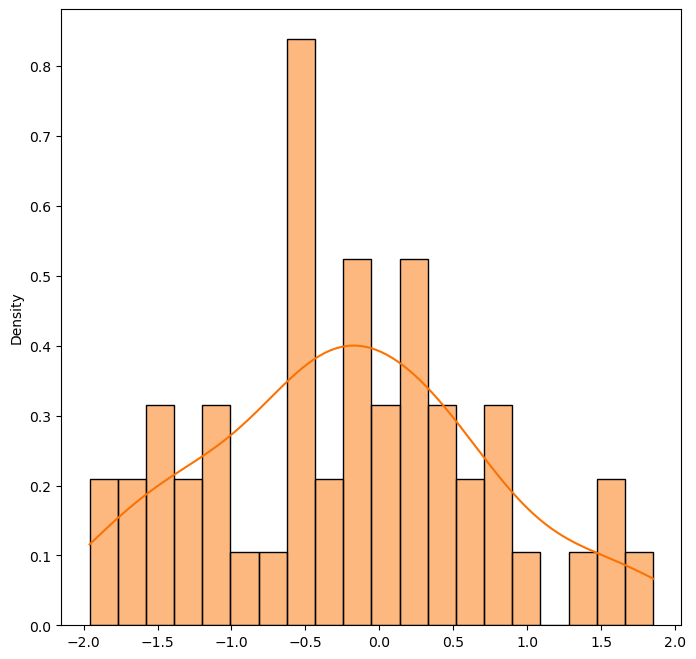

In [ ]:
# Visualize the sample with a histogram and KDE
sns.histplot(x, bins=20, kde=True, stat="density", color="#fc7202")

In [ ]:
# Calculate the empirical CDF values at the sample points: i/n
ecdf_y = np.arange(1, n+1) / n
ecdf_y

array([0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22,
       0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44,
       0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66,
       0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88,
       0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

<Axes: >

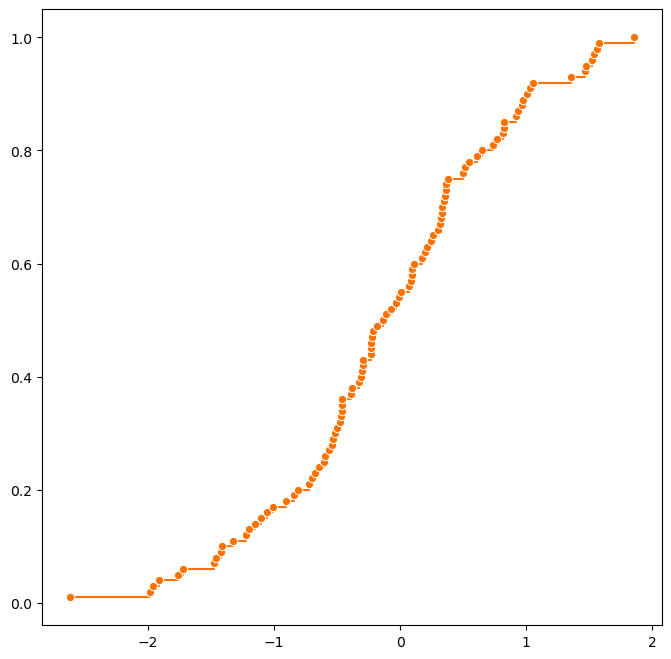

In [ ]:
# Plot the empirical CDF
sns.lineplot(x=x, y=ecdf_y, drawstyle="steps-post", marker="o", color="#fc7202")

In [273]:
# Calculate the theoretical CDF values at the sample points: F(x_i) under H0
F = norm.cdf(x)  # F(x_i)
F

array([0.02501718, 0.02785609, 0.03894686, 0.04227114, 0.06963406,
       0.077115  , 0.07893028, 0.09205833, 0.11107261, 0.12486744,
       0.14509363, 0.15557042, 0.18193275, 0.23581046, 0.27368472,
       0.27404033, 0.28696007, 0.29308907, 0.31936529, 0.32070448,
       0.3215325 , 0.3225289 , 0.38166771, 0.38526039, 0.40743296,
       0.40743933, 0.41068771, 0.44501577, 0.45396565, 0.49461555,
       0.5269194 , 0.54416113, 0.5680329 , 0.57803194, 0.58272264,
       0.5955953 , 0.6233334 , 0.63443332, 0.64642929, 0.69030468,
       0.70628362, 0.74140679, 0.76988452, 0.77858846, 0.79461658,
       0.8547721 , 0.928628  , 0.93612438, 0.94285637, 0.96800706])

The Kolmogorov–Smirnov statistic measures the **largest vertical distance** between the empirical CDF and the theoretical CDF.

This maximum difference can occur **above** or **below** the theoretical curve:

- **D+** measures where the empirical CDF is **above** the theoretical one  
- **D−** measures where the empirical CDF is **below** the theoretical one  
The final **two-sided KS statistic** takes the **larger of the two**:

So we check both sides, since the data might deviate from the theoretical distribution either by being **too large** (ECDF above) or **too small** (ECDF below).


In [274]:
# Compute KS statistic D exactly (two-sided) (D+ and D-)
D_plus_vals  = ecdf_y - F
D_minus_vals = F - (np.arange(0, n) / n)


In [275]:
D_plus  = np.max(D_plus_vals)
D_minus = np.max(D_minus_vals)
D_calc  = max(D_plus, D_minus)

In [277]:
# Value of KS statistic
D_calc

np.float64(0.13357070563896067)

Computed D (manual): 0.133571
scipy kstest D     : 0.133571
Difference          : 0.000e+00
p-value (two-sided) : 0.306422


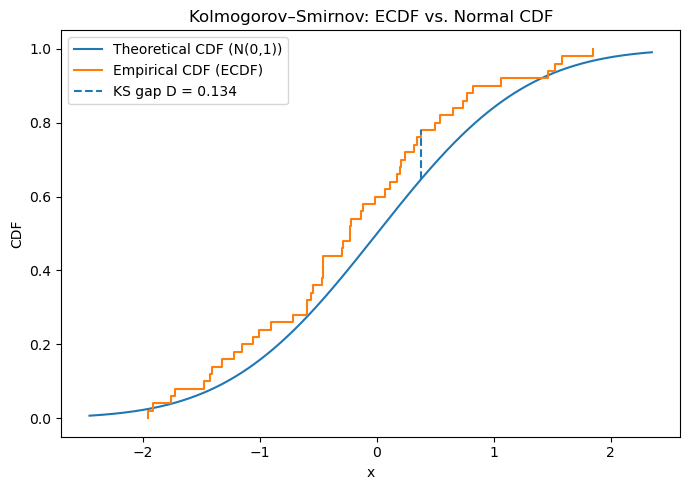

In [278]:
# Locate where the max gap occurs (for plotting the vertical segment)
if D_plus >= D_minus:
    i_star = np.argmax(D_plus_vals)
    x_star = x[i_star]
    y_ecdf_star = ecdf_y[i_star]           # i/n
    y_cdf_star  = F[i_star]
else:
    i_star = np.argmax(D_minus_vals)
    x_star = x[i_star]
    y_ecdf_star = (i_star) / n             # (i-1)/n
    y_cdf_star  = F[i_star]

# Verify with scipy.stats.kstest
stat, pval = kstest(x, 'norm')  # compares sample to N(0,1) by default
print(f"Computed D (manual): {D_calc:.6f}")
print(f"scipy kstest D     : {stat:.6f}")
print(f"Difference          : {abs(D_calc - stat):.3e}")
print(f"p-value (two-sided) : {pval:.6g}")

# Plot ECDF vs theoretical CDF and highlight D
# Build step for full ECDF curve
x_steps = np.r_[x[0], x, x[-1]]
y_steps = np.r_[0.0, ecdf_y, 1.0]

# Smooth grid for theoretical CDF
grid = np.linspace(x.min()-0.5, x.max()+0.5, 800)
cdf_grid = norm.cdf(grid)

plt.figure(figsize=(7,5))

# Theoretical CDF
plt.plot(grid, cdf_grid, label="Theoretical CDF (N(0,1))")

# Empirical CDF (step)
plt.step(x_steps, y_steps, where="post", label="Empirical CDF (ECDF)")

# Vertical segment showing the max gap D at x_star
y1, y2 = y_ecdf_star, y_cdf_star
plt.vlines(x_star, min(y1, y2), max(y1, y2), linestyles="--", label=f"KS gap D = {D_calc:.3f}")

# Cosmetics
plt.xlabel("x")
plt.ylabel("CDF")
plt.title("Kolmogorov–Smirnov: ECDF vs. Normal CDF")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

#### <font color='#fc7202'>Task 3:</font>  
1. Standardize all numeric variables and store them in a new DataFrame called `wine_data_standard`.  
2. Visualize the variable `density` before and after standardization to see that the shape of the distribution stays the same, while the center and scale change.  
3. Run the Kolmogorov–Smirnov test for each numeric variable in two ways:  
   - On the **raw data**, using `args=(mean, sd)` to specify the parameters.  
   - On the **standardized data**, comparing directly against `'norm'` (the standard normal distribution).  

In [44]:
wine_data_standard = wine_data.copy()
wine_data_standard[columns_to_check] = (wine_data_standard[columns_to_check] - wine_data_standard[columns_to_check].mean()) / wine_data_standard[columns_to_check].std()

wine_data_standard.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,5
1,-0.298454,1.966827,-1.391037,0.043403,0.223805,0.872365,0.624168,0.028252,-0.719708,0.128910,-0.584594,5
2,-0.298454,1.296660,-1.185699,-0.169374,0.096323,-0.083643,0.228975,0.134222,-0.331073,-0.048074,-0.584594,5
3,1.654339,-1.384011,1.483689,-0.453077,-0.264878,0.107558,0.411372,0.664069,-0.978798,-0.461036,-0.584594,6
4,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,5


Text(0.5, 1.0, 'Standardized')

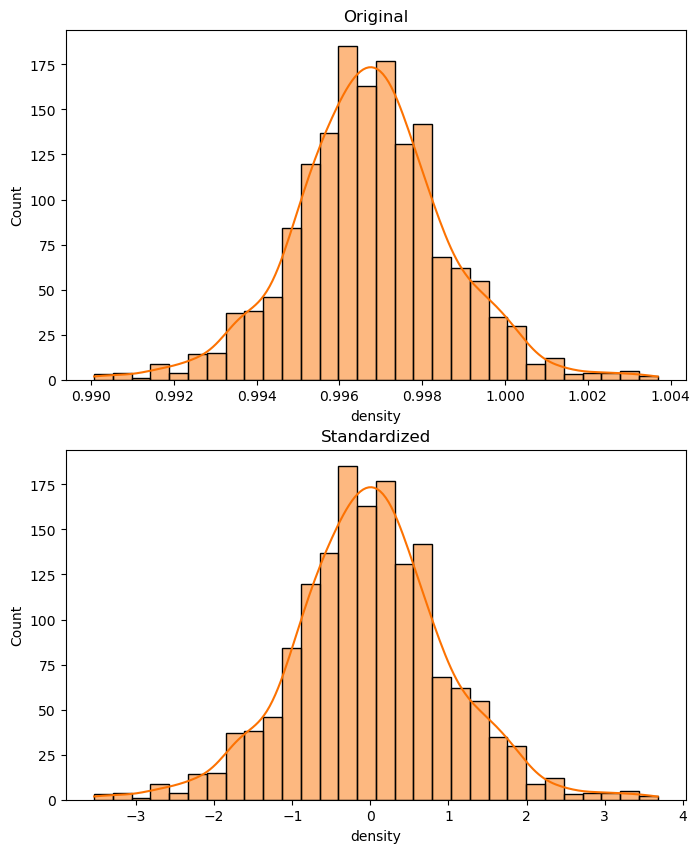

In [198]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# Original histogram and Q–Q
sns.histplot(wine_data.density, bins=30, kde=True, color='#fc7202', ax=axes[0])
axes[0].set_title(f'Original')

sns.histplot(wine_data_standard.density, bins=30, kde=True, color='#fc7202', ax=axes[1])
axes[1].set_title(f'Standardized')

In [279]:
for col in columns_to_check:
    stat, p_value = kstest(wine_data[col], 'norm', args=(np.mean(wine_data[col]),
                                                         np.std(wine_data[col], ddof=1)))
    print(f"{col}: D={stat:.4f}, p-value={p_value:.4f}")

fixed acidity: D=0.1105, p-value=0.0000
volatile acidity: D=0.0547, p-value=0.0001
citric acid: D=0.0839, p-value=0.0000
residual sugar: D=0.2607, p-value=0.0000
chlorides: D=0.2596, p-value=0.0000
free sulfur dioxide: D=0.1112, p-value=0.0000
total sulfur dioxide: D=0.1210, p-value=0.0000
density: D=0.0448, p-value=0.0032
pH: D=0.0404, p-value=0.0106
sulphates: D=0.1248, p-value=0.0000
alcohol: D=0.1215, p-value=0.0000


In [280]:
for col in columns_to_check:
    stat, p_value = kstest(wine_data_standard[col], 'norm')
    print(f"{col}: D={stat:.4f}, p-value={p_value:.4f}")

fixed acidity: D=0.1105, p-value=0.0000
volatile acidity: D=0.0547, p-value=0.0001
citric acid: D=0.0839, p-value=0.0000
residual sugar: D=0.2607, p-value=0.0000
chlorides: D=0.2596, p-value=0.0000
free sulfur dioxide: D=0.1112, p-value=0.0000
total sulfur dioxide: D=0.1210, p-value=0.0000
density: D=0.0448, p-value=0.0032
pH: D=0.0404, p-value=0.0106
sulphates: D=0.1248, p-value=0.0000
alcohol: D=0.1215, p-value=0.0000


## Part 2: Simulating Continuous Data

Yesterday, we simulated data for a **discrete random variable** (the roll of a die).  
When we rolled the die only a few times (for example, 7 rolls), the results looked noisy and irregular,  
and the underlying distribution (where all outcomes are equally likely) was not yet visible.  
As we increased the number of rolls, however, the distribution began to *stabilize* and approach the expected uniform shape.

Today, we’ll do something very similar, but this time for a **continuous random variable**.  
Instead of discrete dice outcomes, we’ll simulate measurements that follow a **normal distribution**,  
with a **mean of 10.5** and a **standard deviation of 1.8**.


#### <font color='#fc7202'>Task 4:</font>  
1. Generate a **small sample** of size 15 from this distribution and plot its histogram.  
2. Then, generate a **larger sample**. Choose the size yourself (for example, a few hundred or a few thousand observations), and plot a second histogram on the same scale.  

> *Hint:* use `np.random.normal(mean, sd, size=n)` to generate the data.


In [226]:
mean1 = 10.5
std1 = 1.8

np.random.seed(42)
sample15 = np.random.normal(loc=mean1, scale=std1, size=15)

In [227]:
sample15

array([11.39408548, 10.25112426, 11.66583937, 13.24145374, 10.07852393,
       10.07855348, 13.34258307, 11.88138251,  9.65494611, 11.47660808,
        9.66584815,  9.66168644, 10.93553209,  7.05609556,  7.3951479 ])

<Axes: ylabel='Count'>

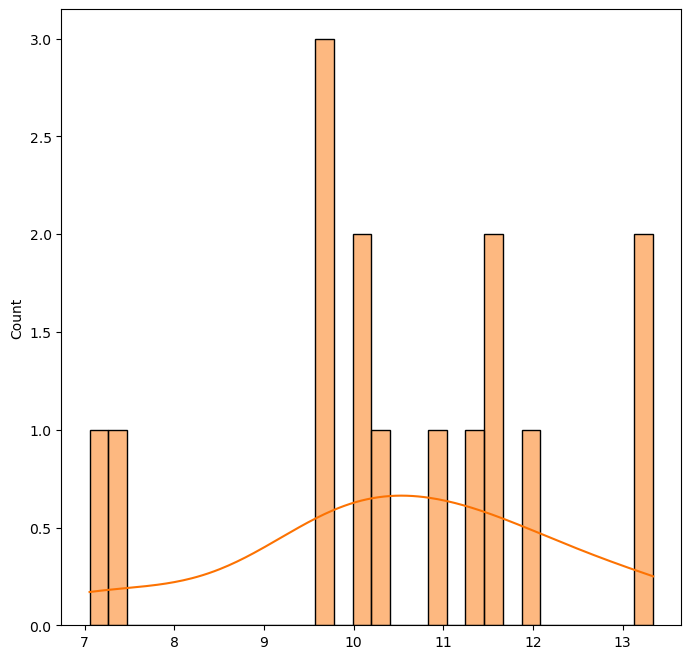

In [228]:
sns.histplot(sample15, bins=30, kde=True, color='#fc7202')

In [229]:
np.random.seed(42)
sample1000 = np.random.normal(loc=mean1, scale=std1, size=1000)

<Axes: ylabel='Count'>

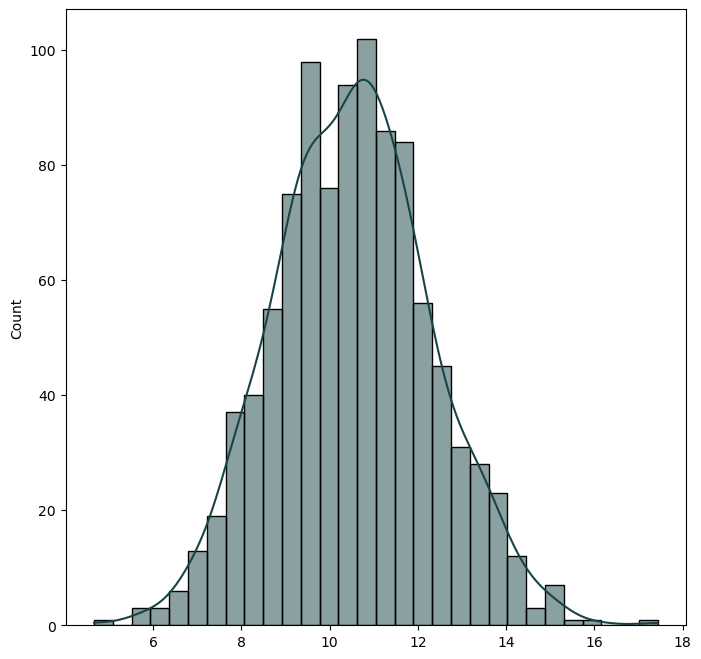

In [230]:
sns.histplot(sample1000, bins=30, kde=True, color='#184445')

#### <font color='#fc7202'>Task 5:</font>  
Now, let’s use the same normal model to estimate a probability through simulation.  
Assume that values **≤ 7.0** are considered unusually low for this measurement.  
What is the probability that the next observation will fall into this range?

1. Draw one sufficiently large synthetic sample from the same normal distribution.  
2. Count how many of your simulated values are ≤ 7.0.  
3. Compute the fraction of such observations (this represents your simulated probability).  
4. Compare your simulated result with the analytical probability obtained using  
\begin{equation} P(X \le 7.0) = \texttt{norm.cdf(7.0, loc=mean, scale=sd)} \end{equation}

> *Hint:* You can use `np.mean(sample <= 7.0)` to calculate the fraction of simulated values ≤ 7.0.



In [282]:
# Probability that a new observation is less than or equal to 7
np.sum(sample1000 <= 7)/1000

np.float64(0.02)

In [281]:
p_analytical = norm.cdf(7.0, loc=10.5, scale=1.8)
p_analytical

np.float64(0.025920939357843)

#### <font color='#fc7202'>Task 6:</font>
Assume the true process follows a normal distribution with mean = 10.0 and standard deviation of 1.8.

You run an experiment with *n* = 600 observations and obtain a sample mean of 10.5.  
How surprising is this result if the true mean is really 10.0?

1. Simulate many experiments: in each repetition, draw `n = 600` values from `Normal(10.0, 1.8)`.  
2. Compute the sample mean for each repetition.  
3. Estimate the probability 
   \begin{equation} P(\bar{X} \ge 10.5 \mid \mu=10.0, \sigma=1.8, n=600) \end{equation}
   as the fraction of simulated means that are ≥ 10.5.  
4. Visualize the sampling distribution of the simulated means (histogram) and add a vertical line at 10.5.  


In [283]:
# Parameters
mu_true = 10.0
sigma_true = 1.8
n = 600
observed_mean = 10.5

# Number of simulated experiments
R = 20_000  # you can increase for higher precision

# Simulate many experiments and compute sample means
means = np.mean(np.random.normal(mu_true, sigma_true, size=(R, n)), axis=1)

# Estimate the probability of sample mean ≥ observed_mean
p_simulated = np.mean(means >= observed_mean)

# Analytical probability for comparison
p_analytical = 1 - norm.cdf(observed_mean, loc=mu_true, scale=sigma_true / np.sqrt(n))

print(f"Simulated P(mean ≥ {observed_mean}): {p_simulated:.5f}")
print(f"Analytical P(mean ≥ {observed_mean}): {p_analytical:.5f}")

Simulated P(mean ≥ 10.5): 0.00000
Analytical P(mean ≥ 10.5): 0.00000


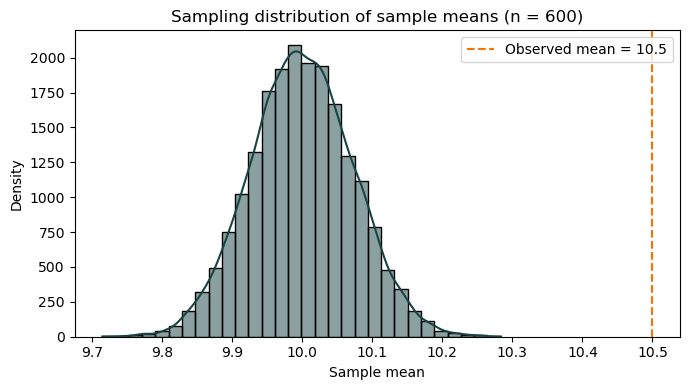

In [284]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.histplot(means, bins=30, kde=True, color='#184445')


# Vertical line at observed mean
ax.axvline(observed_mean, color='#fc7202', linestyle='--', label=f'Observed mean = {observed_mean}')
ax.legend()
ax.set_xlabel("Sample mean")
ax.set_ylabel("Density")
ax.set_title(f"Sampling distribution of sample means (n = {n})")

plt.tight_layout()
plt.show()

In the previous task, we repeated the experiment many times and computed the sample mean each round.  
The histogram of those sample means looked bell-shaped.  

That is exactly the **Central Limit Theorem (CLT)** in action:
- Regardless of the original data’s distribution (as long as observations are independent and identically distributed (i.i.d.) with finite variance),
- the sampling distribution of the mean $\bar X$ becomes approximately **Normal** as $n$ grows,
- centered at the true mean $\mu$ with standard deviation $\sigma/\sqrt{n}$.

So, the bell shape you observed for the collection of sample means is *evidence of the CLT*.

#### <font color='#fc7202'>Task 7:</font>
Let’s test whether the sample mean looks approximately normal even when the underlying data are not normal.
We’ll use an exponential distribution.

In `Python`, we can simulate such data using:
```python
np.random.exponential(scale=1/lam, size=n)
```
where:
- `lam` is the rate parameter *λ*,
- `1/lam` is the mean (the `scale` in `NumPy`’s function), and
- `size` is the number of values you want to generate.

1. Choose a sample size *n* (for example, 600) and a rate *λ* (for example, 0.1).
2. Repeat the experiment many times (e.g., 20 000 repetitions): in each repetition, draw *n* values from `np.random.exponential(scale=1/lam, size=n)` and compute their sample mean.
3. Plot a histogram of all simulated sample means.

In [260]:
#from scipy.stats import expon
lam = 0.1          # rate λ
n = 600         # number of simulated observations

# Simulate one sample from Exp(λ)
rng = np.random.default_rng(42)
sample = rng.exponential(scale=1/lam, size=n)  # scale = 1/λ

In [261]:
sample

array([24.04208604, 23.36189656, 23.84761   ,  2.7979429 ,  0.864374  ,
       14.52660516, 14.09960694, 31.24295957,  0.79294197, 10.46560847,
        0.70436307, 10.89023628, 17.31327353,  3.86894825, 12.31585663,
        1.53773254,  0.91577267,  3.15179202,  9.01199275,  4.1298533 ,
       12.4738595 ,  2.23576372, 18.37970264, 12.27085863,  6.55796154,
        4.17086706,  4.53319689,  0.77077147,  1.79632254,  6.85320452,
        3.88680236, 12.64206858,  7.08490627,  2.37929954,  4.61088336,
        6.41556737,  3.43833361,  3.21911221,  8.78914682,  2.96947209,
       13.33702425, 13.90863986, 10.84082928,  0.73028348, 11.34067502,
       13.54337988, 11.22039651,  2.8004912 ,  3.20936191,  1.65735907,
        3.54363513,  0.21139756,  1.67356396, 13.15056845, 39.95756271,
        5.63538092,  2.84039702,  3.97756254,  3.61342223,  1.29633603,
       10.83325135, 13.75848854, 15.07809131, 53.09882796, 21.06660235,
       16.4486584 , 10.43491482,  5.92524199,  0.44453556,  9.56

<Axes: ylabel='Density'>

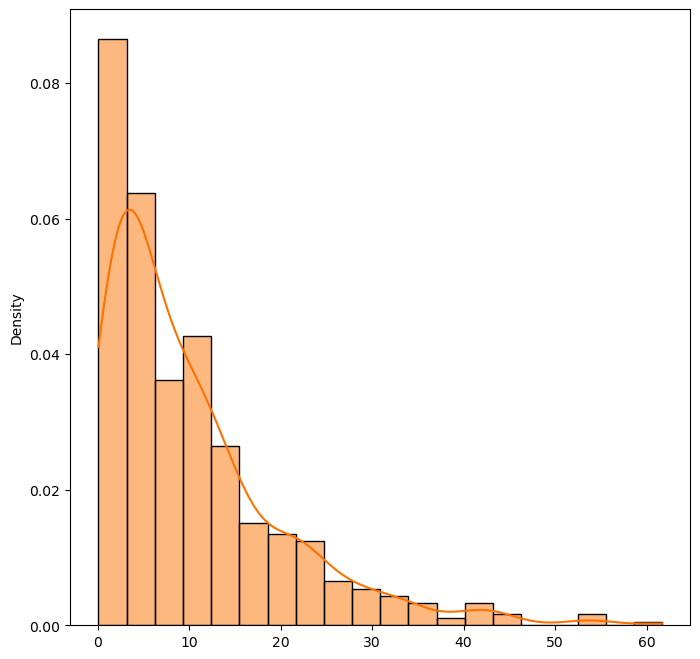

In [285]:
# Visualize the sample with a histogram and KDE
sns.histplot(sample, bins=20, kde=True, stat="density", color="#fc7202")

In [262]:
samples = rng.exponential(scale=1/lam, size=(1000, n))
sample_means = samples.mean(axis=1)

<Axes: ylabel='Count'>

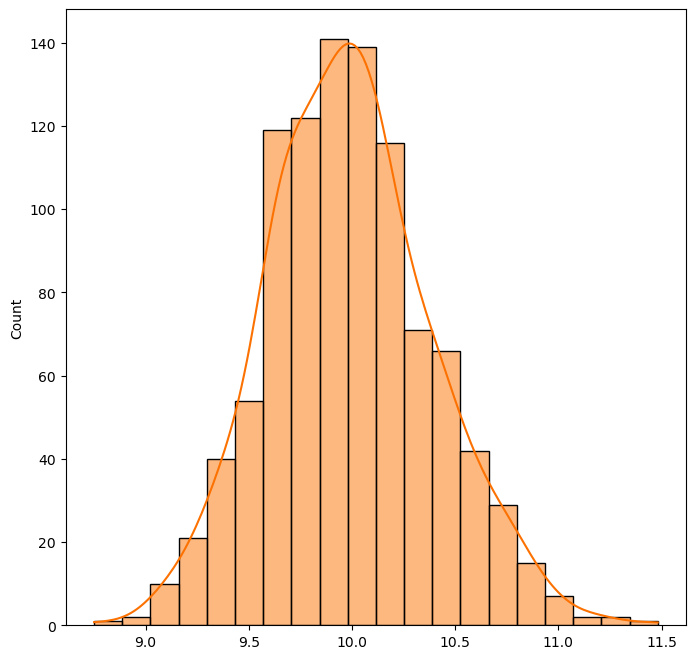

In [286]:
# Visualize the sample means with a histogram and KDE
sns.histplot(sample_means, bins=20, kde=True, color="#fc7202")